# 决策树
## 1. 导入必要的库



In [1]:
import pandas as pd
from math import log2
from pylab import *
import matplotlib.pyplot as plt

- _pandas_ 用于数据处理
- _math.log2_ 用于计算对数
- _pylab_ 和 _matplotlib.pyplot_ 用于绘图

## 2. 加载数据集


In [2]:
def load_dataset():
    path = "xigua.csv"
    data = pd.read_csv(path, header=0, encoding='gbk')
    dataset = []
    for a in data.values:
        dataset.append(list(a))
    attribute = list(data.keys())
    return dataset, attribute
dataset,attribute = load_dataset()
print(attribute,dataset)

['色泽', '根蒂', '敲声', '纹理', '脐部', '触感', '好瓜'] [['青绿', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['乌黑', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '是'], ['乌黑', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['青绿', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '是'], ['乌黑', '稍蜷', '浊响', '稍糊', '稍凹', '软粘', '是'], ['青绿', '硬挺', '清脆', '清晰', '平坦', '软粘', '否'], ['浅白', '稍蜷', '沉闷', '稍糊', '凹陷', '硬滑', '否'], ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '软粘', '否'], ['浅白', '蜷缩', '浊响', '模糊', '平坦', '硬滑', '否'], ['青绿', '蜷缩', '沉闷', '稍糊', '稍凹', '硬滑', '否'], ['青绿', '蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '是'], ['浅白', '蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'], ['乌黑', '稍蜷', '浊响', '清晰', '稍凹', '硬滑', '是'], ['乌黑', '稍蜷', '沉闷', '稍糊', '稍凹', '硬滑', '否'], ['浅白', '硬挺', '清脆', '模糊', '平坦', '硬滑', '否'], ['浅白', '蜷缩', '浊响', '模糊', '平坦', '软粘', '否'], ['青绿', '稍蜷', '浊响', '稍糊', '凹陷', '硬滑', '否']]


- 从CSV文件中加载数据集，并返回数据列表和每个维度的名称

## 3. 计算信息熵
- 计算数据集的信息熵


![根蒂归类集合熵](./mdpic/genti.png) 

以根蒂特征为例，计算根蒂特征的归类集合熵 
$$
当根蒂'稍蜷'时: H(X_{稍蜷}) = -(\frac{3}{7}log_2\frac{3}{7} + \frac{4}{7}log_2\frac{4}{7}) \approx -0.985 \\
当根蒂'蜷缩'时: H(X_{蜷缩}) = -(\frac{5}{8}log_2\frac{5}{8} + \frac{3}{8}log_2\frac{3}{8}) \approx -0.954 \\
当根蒂'硬挺'时: H(X_{硬挺}) = -(\frac{0}{2}log_2\frac{0}{2} + \frac{2}{2}log_2\frac{2}{2}) \approx 0 \\
$$



In [3]:
def calculate_info_entropy(dataset):
    n = len(dataset)
    attribute_count = {}
    for attribute in dataset:
        class_attribute = attribute[-1]
        if class_attribute not in attribute_count.keys():
            attribute_count[class_attribute] = 0
        attribute_count[class_attribute] += 1
    info_entropy = 0
    for class_attribute in attribute_count:
        p = float(attribute_count[class_attribute]) / n
        info_entropy -= p * log2(p)
    return info_entropy


## 4. 划分数据集
- 根据指定维度和值划分数据集

In [4]:
def split_dataset(dataset, i, value):
    split_set = []
    for attribute in dataset:
        if attribute[i] == value:
            reduce_attribute = attribute[:i]
            reduce_attribute.extend(attribute[i+1:])
            split_set.append(reduce_attribute)
    return split_set


## 5. 计算属性熵
- 计算指定维度的属性熵

整个系统的熵为：
$$
H(Y|X_{根蒂}) = \frac{7}{17}H(X_{稍蜷}) + \frac{8}{17}H(X_{蜷缩}) + \frac{2}{17}H(X_{硬挺})
$$

In [5]:
def calculate_attribute_entropy(dataset, i, values):
    attribute_entropy = 0
    for value in values:
        sub_dataset = split_dataset(dataset, i, value)
        p = len(sub_dataset) / float(len(dataset))
        attribute_entropy += p * calculate_info_entropy(sub_dataset)
    return attribute_entropy


## 6. 计算信息增益


$$
g(D, X_{根蒂}) = H(D) - H(D|X_{根蒂}) \\
\dots \\
g(D, X_{触感}) = H(D) - H(D|X_{触感})
$$

In [6]:
def calculate_info_gain(dataset, info_entropy, i):
    attribute = [example[i] for example in dataset]
    values = set(attribute)
    attribute_entropy = calculate_attribute_entropy(dataset, i, values)
    info_gain = info_entropy - attribute_entropy
    return info_gain


## 7. 根据信息增益划分数据集
- 根据信息增益选择最佳划分维度

$$
sort(\begin{bmatrix}
g(D, X_{根蒂}) = H(D) - H(D|X_{根蒂}) \\
\dots \\
g(D, X_{触感}) = H(D) - H(D|X_{触感})
\end{bmatrix}) 
$$

In [7]:
def split_by_info_gain(dataset):
    attribute_num = len(dataset[0]) - 1
    info_entropy = calculate_info_entropy(dataset)
    max_info_gain = 0
    best_attribute = -1
    for i in range(attribute_num):
        info_gain = calculate_info_gain(dataset, info_entropy, i)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_attribute = i
    return best_attribute

## 8. 创建决策树


In [8]:
def create_tree(dataset, attribute):
    class_list = [example[-1] for example in dataset]
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    best_attribute = split_by_info_gain(dataset)
    best_attribute_name = attribute[best_attribute]
    tree = {best_attribute_name:{}}
    del(attribute[best_attribute])
    attribute_values = [example[best_attribute] for example in dataset]
    values = set(attribute_values)
    for value in values:
        sub_attribute = attribute[:]
        tree[best_attribute_name][value] = create_tree(split_dataset(dataset, best_attribute, value), sub_attribute)
    return tree
tree = create_tree(dataset,attribute)
print(tree)


{'纹理': {'模糊': '否', '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '清晰': {'根蒂': {'硬挺': '否', '稍蜷': {'色泽': {'乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}, '青绿': '是'}}, '蜷缩': '是'}}}}


## 9. 绘制决策树

### 9.1 绘制决策树节点

In [9]:
attribute_node = dict(boxstyle="round", color='#00B0F0')
class_node = dict(boxstyle="circle", color='#00F064')
arrow = dict(arrowstyle="<-", color='#000000')

In [10]:

def get_num_leaf(tree):
    numLeafs = 0
    firstStr = list(tree.keys())[0]
    secondDict = tree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += get_num_leaf(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def get_depth_tree(tree):
    maxDepth = 0
    firstStr = list(tree.keys())[0]
    secondDict = tree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + get_depth_tree(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


In [11]:
def plot_text(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(tree, parentPt, nodeTxt):
    numLeafs = get_num_leaf(tree)
    depth = get_depth_tree(tree)
    firstStr = list(tree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plot_text(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, attribute_node) 
    secondDict = tree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, class_node)
            plot_text((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

# 绘制箭头
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow)


def createPlot(tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(get_num_leaf(tree))
    plotTree.totalD = float(get_depth_tree(tree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(tree, (0.5, 1.0), '')
    plt.show()


## 10. 设置默认字体并绘制决策树

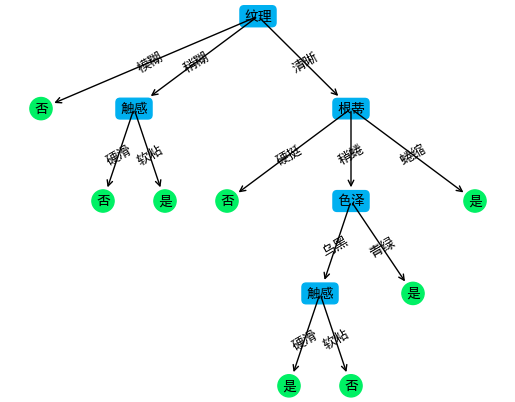

In [12]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

createPlot(tree)